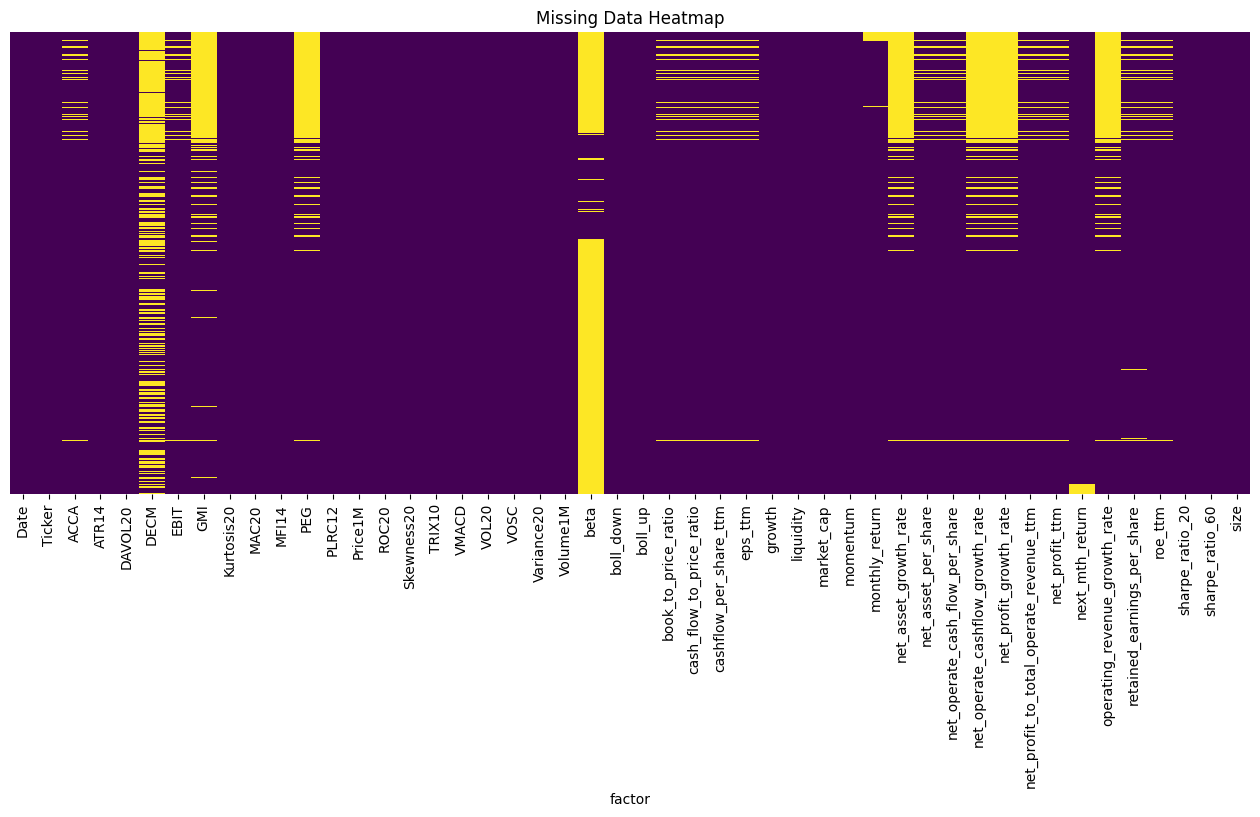

Correlation Matrix:

factor
next_mth_return                            1.000000
beta                                       0.096965
liquidity                                  0.060948
cash_flow_to_price_ratio                   0.050452
GMI                                        0.045850
Variance20                                 0.045798
VOL20                                      0.042020
net_profit_growth_rate                     0.029736
VOSC                                       0.024082
Skewness20                                 0.017724
net_asset_growth_rate                      0.016659
book_to_price_ratio                        0.016573
Volume1M                                   0.015788
DAVOL20                                    0.015788
PLRC12                                     0.015013
Kurtosis20                                 0.013913
VMACD                                      0.012148
net_operate_cashflow_growth_rate           0.008651
DECM                                

factor,Date,Ticker,ACCA,ATR14,DAVOL20,DECM,EBIT,GMI,Kurtosis20,MAC20,...,net_profit_growth_rate,net_profit_to_total_operate_revenue_ttm,net_profit_ttm,next_mth_return,operating_revenue_growth_rate,retained_earnings_per_share,roe_ttm,sharpe_ratio_20,sharpe_ratio_60,size
0,2020-01-01,A,-0.020983,2.205727,2317103.00,NaN,9.200000e+08,NaN,17.166927,-5.860882,...,NaN,0.134669,7.190000e+08,-0.066497,NaN,0.281908,0.147548,0.276128,0.386987,2.503639e+10
1,2020-01-01,AAPL,-0.071824,1.977781,9249430.00,0.0,6.996400e+10,NaN,17.182466,-8.691087,...,NaN,0.209136,5.741100e+10,-0.116798,NaN,0.984340,0.878664,0.278281,0.389166,1.185601e+12
2,2020-01-01,ACGL,-0.034217,1.975959,9276005.50,NaN,1.704239e+09,NaN,17.140918,-13.428242,...,NaN,0.169508,1.405521e+09,-0.084466,NaN,32.873821,0.107243,0.273005,0.391084,1.660511e+10
3,2020-01-01,ACN,-0.083803,2.095281,9349302.25,NaN,6.807402e+09,NaN,15.769146,-4.240841,...,NaN,0.115231,5.107839e+09,-0.119975,NaN,19.769222,0.300452,0.313054,0.382027,1.302482e+11
4,2020-01-01,ADBE,-0.019231,2.199852,9429585.75,NaN,4.292000e+09,NaN,15.758405,13.623323,...,NaN,0.408766,5.260000e+09,-0.017144,NaN,44.550204,0.396562,0.317413,0.385026,1.518491e+11


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("Input.csv")

# Melt: convert wide stock columns into rows (Date, factor, Ticker, Value)
df_long = df.melt(id_vars=['Date', 'factor'], var_name='Ticker', value_name='Value')

# Pivot: reshape so that each (Date, Ticker) is a row, and each factor is a column
df_pivot = df_long.pivot_table(index=['Date', 'Ticker'], columns='factor', values='Value').reset_index()

plt.figure(figsize=(16, 6))
sns.heatmap(df_pivot.iloc[:, :].isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missing Data Heatmap")
plt.show()

# Compute correlation matrix
corr_matrix = df_pivot.corr(numeric_only=True)

# Display the full correlation matrix
print("Correlation Matrix:\n")
print(corr_matrix['next_mth_return'].sort_values(ascending=False))  # correlations with the target


# Optional: preview reshaped data
df_pivot.head()

In [6]:
# Define feature categories (sample names, adjust as per your dataset)
feature_categories = {
    'technical': [
        'ACCA', 'ATR14', 'DAVOL20', 'Kurtosis20', 'MAC20', 'MFI14',
        'PLRC12', 'Price1M', 'ROC20', 'Skewness20', 'TRIX10', 'VMACD',
        'VOL20', 'VOSC', 'Variance20', 'Volume1M', 'boll_down', 'boll_up',
        'momentum', 'sharpe_ratio_20', 'sharpe_ratio_60'
    ],
    'fundamental': [
        'book_to_price_ratio', 'cash_flow_to_price_ratio',
        'cashflow_per_share_ttm', 'eps_ttm', 'net_asset_per_share',
        'net_operate_cash_flow_per_share', 'retained_earnings_per_share',
        'roe_ttm', 'size', 'market_cap', 'liquidity' , 'beta'
    ],
    'growth': [
        'growth', 'net_asset_growth_rate', 'net_operate_cashflow_growth_rate',
        'net_profit_growth_rate', 'operating_revenue_growth_rate'
    ],
    'profitability': [
        'EBIT', 'GMI', 'net_profit_ttm', 'net_profit_to_total_operate_revenue_ttm'
    ],
    'target': ['next_mth_return']
}

# Ensure chronological order per stock
df_pivot = df_pivot.sort_values(['Ticker', 'Date'])

# ----------------------------
# A. Technical: forward-fill + rolling median
tech_cols = feature_categories['technical']
df_pivot[tech_cols] = df_pivot.groupby('Ticker')[tech_cols].ffill()
for col in tech_cols:
    df_pivot[col] = df_pivot.groupby('Ticker')[col].transform(
        lambda x: x.fillna(x.rolling(7, min_periods=1).median())
    )

# ----------------------------
# B. Fundamental: fill with global median (or sector-wise if available)
fund_cols = feature_categories['fundamental']
df_pivot[fund_cols] = df_pivot[fund_cols].fillna(df_pivot[fund_cols].median())

# ----------------------------
# C. Growth: ticker-specific median
growth_cols = feature_categories['growth']
df_pivot[growth_cols] = df_pivot.groupby('Ticker')[growth_cols].transform(
    lambda x: x.fillna(x.median())
)

# ----------------------------
# D. Profitability: forward-fill + fallback median
prof_cols = feature_categories['profitability']
df_pivot[prof_cols] = df_pivot.groupby('Ticker')[prof_cols].ffill()
df_pivot[prof_cols] = df_pivot[prof_cols].fillna(df_pivot[prof_cols].median())

# Drop rows with missing target
df_pivot = df_pivot.dropna(subset=['next_mth_return'])


# Check for remaining missing values
missing_values = df_pivot[
    feature_categories['technical'] +
    feature_categories['fundamental'] +
    feature_categories['growth'] +
    feature_categories['profitability']
].isnull().sum()

if missing_values.sum() > 0:
    print("Warning: Some missing values remain after imputation:")
    print(missing_values[missing_values > 0])
    print("\nConsider additional imputation strategies for these columns.")
else:
    print("All missing values successfully imputed!")
print("\nPreprocessing complete!")
print(f"Final shape: {df_pivot.shape}")
df_pivot.head()

factor
ACCA    424
dtype: int64

Consider additional imputation strategies for these columns.

Preprocessing complete!
Final shape: (10090, 48)


factor,Date,Ticker,ACCA,ATR14,DAVOL20,DECM,EBIT,GMI,Kurtosis20,MAC20,...,net_profit_growth_rate,net_profit_to_total_operate_revenue_ttm,net_profit_ttm,next_mth_return,operating_revenue_growth_rate,retained_earnings_per_share,roe_ttm,sharpe_ratio_20,sharpe_ratio_60,size
0,2020-01-01,A,-0.020983,2.205727,2.317103e+06,NaN,920000000.0,0.002802,17.166927,-5.860882,...,0.036364,0.134669,719000000.0,-0.066497,0.083716,0.281908,0.147548,0.276128,0.386987,2.503639e+10
203,2020-02-01,A,-0.020983,2.955714,2.589194e+06,NaN,920000000.0,0.002802,16.402929,-7.600522,...,0.036364,0.134669,719000000.0,-0.070715,0.083716,0.281908,0.147548,0.281255,0.390273,2.382463e+10
406,2020-03-01,A,-0.020983,6.841177,5.168477e+06,NaN,920000000.0,0.002802,16.647414,-6.443377,...,0.036364,0.134669,719000000.0,0.070371,0.083716,0.281908,0.147548,0.283032,0.382931,2.056655e+10
610,2020-04-01,A,-0.020983,4.221146,3.614272e+06,NaN,920000000.0,0.002802,16.875365,-6.203324,...,0.036364,0.134669,719000000.0,0.149752,0.083716,0.281908,0.147548,0.280668,0.379792,2.174991e+10
814,2020-05-01,A,-0.020983,3.521360,3.515585e+06,NaN,920000000.0,0.002802,16.426503,-6.226780,...,0.036364,0.134669,719000000.0,0.002610,0.083716,0.281908,0.147548,0.286341,0.381561,2.335890e+10


In [7]:
# Convert Date column to datetime
df_pivot['Date'] = pd.to_datetime(df_pivot['Date'])

# Filter out columns with >50% missing values (as a safeguard)
na_ratio = df_pivot.isna().mean()
cols_keep = na_ratio[na_ratio <= 0.5].index.tolist()

# Ensure essential columns are kept
for col in ['Date', 'Ticker', 'next_mth_return']:
    if col not in cols_keep:
        cols_keep.append(col)

# Keep only selected columns
df = df_pivot[cols_keep].copy()

# Fill remaining small gaps with column-wise median
df = df.fillna(df.median(numeric_only=True))

# ----------------------------
# LAG Feature Generation
LAGS = [1, 2, 5]
base_feats = df.columns.difference(['Date', 'Ticker', 'next_mth_return'])

import warnings
warnings.filterwarnings('ignore')

for col in base_feats:
    for lag in LAGS:
        df[f"{col}_lag{lag}"] = df.groupby('Ticker')[col].shift(lag)

# Drop rows with NA after shifting
df = df.dropna().reset_index(drop=True)

# ----------------------------
# Create binary classification target
df['target'] = df['next_mth_return'].apply(lambda x: 1 if x > 0 else 0)

# ----------------------------
# Time-Based Train/Test Split
cutoff_date = df['Date'].quantile(0.9)

df_train = df[df['Date'] <= cutoff_date]
df_test = df[df['Date'] > cutoff_date]

# Final input/output split
X_train = df_train.drop(columns=['Date', 'Ticker', 'next_mth_return', 'target'])
y_train = df_train['target']
X_test = df_test.drop(columns=['Date', 'Ticker', 'next_mth_return', 'target'])
y_test = df_test['target']

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (8108, 176), Test size: (880, 176)


In [8]:
cutoff_date

Timestamp('2023-07-01 00:00:00')

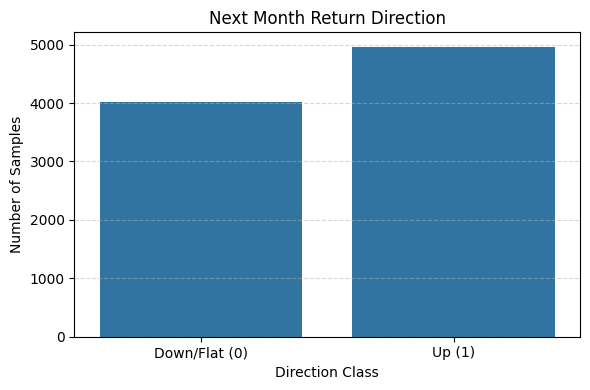

In [9]:
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title("Next Month Return Direction")
plt.xlabel("Direction Class")
plt.ylabel("Number of Samples")
plt.xticks([0, 1], ["Down/Flat (0)", "Up (1)"])
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

 Model Evaluation Complete
Accuracy: 0.5352

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.19      0.28       419
           1       0.54      0.85      0.66       461

    accuracy                           0.54       880
   macro avg       0.53      0.52      0.47       880
weighted avg       0.53      0.54      0.48       880



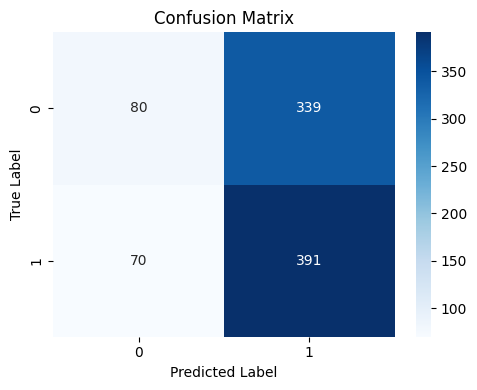

In [10]:
# 📘 SECTION 4: Model Training, Prediction & Evaluation

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ----------------------------
# Final Train-Test Split (with Metadata for Backtest)

# Save next month's return and identifiers for test set (used in backtest)
nxt_mnth_ret_test = df_test['next_mth_return']
date_and_ticker_test = df_test[['Date', 'Ticker']]

# Drop non-feature columns
X_train = df_train.drop(columns=['next_mth_return', 'target', 'Date', 'Ticker'])
y_train = df_train['target']
X_test = df_test.drop(columns=['next_mth_return', 'target', 'Date', 'Ticker'])
y_test = df_test['target']

# ----------------------------
# Train XGBoost Classifier
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# ----------------------------
# Predict Classes and Probabilities
y_pred = model.predict(X_test)
proba_test = model.predict_proba(X_test)[:, 1]  # Probability of class '1'

# ----------------------------
# Evaluate Performance
print(" Model Evaluation Complete")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Visual: Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

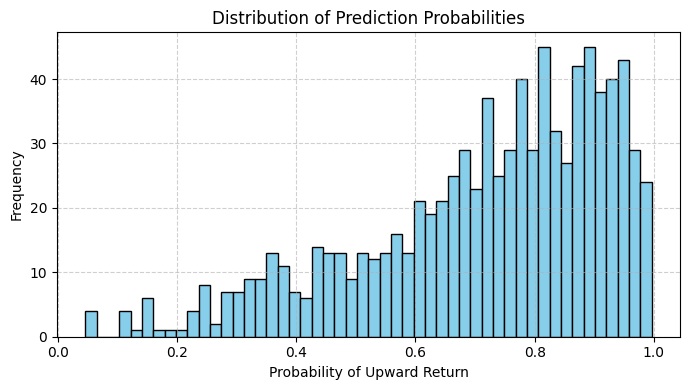

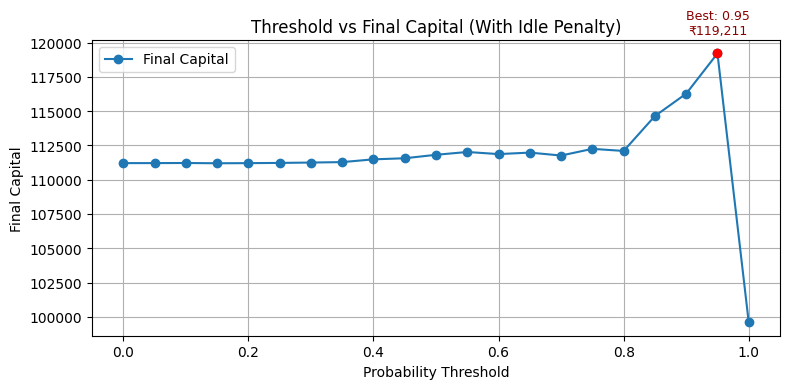

In [11]:
# Reattach metadata and probabilities for simulation
X_test['Date'] = date_and_ticker_test['Date']
X_test['Ticker'] = date_and_ticker_test['Ticker']
X_test['next_mth_return'] = nxt_mnth_ret_test
X_test['probs'] = proba_test

def run_backtest_with_threshold(df_input, thr=0.5, initial_capital=100000, idle_penalty=0.001):
    """
    Run a backtest where:
    - Trades are made only when model confidence > threshold
    - If no trades on a day, apply idle penalty (simulated loss for unused capital)
    """
    df = df_input.copy()
    df['signal'] = df['probs'].apply(lambda x: 1 if x > thr else 0)

    capital = initial_capital
    dates = sorted(df['Date'].unique())

    for date in dates:
        df_date = df[df['Date'] == date].copy()
        df_date = df_date[df_date['signal'] == 1]

        # If no stocks qualify, simulate idle day with small penalty
        if df_date.empty:
            capital *= (1 - idle_penalty)  # 0.1% drop simulating inflation/fees/erosion
            continue

        # Normalize portfolio weights using probabilities
        df_date['probs'] /= df_date['probs'].sum()

        final_capital = 0
        for _, row in df_date.iterrows():
            invest = capital * row['probs']
            new_capital = invest * (1 + row['next_mth_return'])
            final_capital += new_capital

        capital = final_capital

    return capital

# ----------------------------
# Run backtest over thresholds
thresholds = np.linspace(0, 1, 21)
results = [(thr, run_backtest_with_threshold(X_test, thr=thr)) for thr in thresholds]

# Extract best point
best_thr, best_cap = max(results, key=lambda x: x[1])

#Distribution of Prediction Probabilites
plt.figure(figsize=(7, 4))
plt.hist(proba_test, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Prediction Probabilities")
plt.xlabel("Probability of Upward Return")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Plot
plt.figure(figsize=(8, 4))
plt.plot(*zip(*results), marker='o', label='Final Capital')

# Add best-performing point
plt.scatter(best_thr, best_cap, color='red', zorder=5)
plt.text(best_thr, best_cap * 1.01, f"Best: {best_thr:.2f}\n₹{best_cap:,.0f}",
         ha='center', va='bottom', fontsize=9, color='darkred')

plt.title("Threshold vs Final Capital (With Idle Penalty)")
plt.xlabel("Probability Threshold")
plt.ylabel("Final Capital")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Overall Approach

Our pipeline is structured into three major stages:

1. **Data Cleaning & Preprocessing**  
2. **Feature Engineering**  
3. **Target Construction & Predictive Modeling**

The dataset initially presented each row as a combination of a date and a financial factor, with columns representing stock tickers. To prepare it for modeling, we reshaped the data so that each row represented a specific **(Date, Ticker)** pair with all factor values as features.

While analyzing the dataset, we identified `next_mth_return` as a suitable target variable, representing the stock's return in the next month. This naturally aligned with our objective of predicting **future performance**.

---

### Missing Value Handling

Handling missing values was tailored to feature types:

- **Technical indicators**: forward-filled and smoothed using rolling medians  
- **Fundamental metrics**: filled with global medians  
- **Growth metrics**: imputed using ticker-level medians  
- **Profitability metrics**: combined forward-fill and median fallback  

Columns with excessive missingness were dropped to reduce noise and instability.

---

### Feature Engineering

Time-series lag features (e.g., 1, 2, and 5-month lags) were added to capture historical behavior.  
The target `next_mth_return` was binarized:

- **1** → if the stock’s return next month is positive  
- **0** → otherwise

---

### Time-Based Train/Test Split

To avoid **look-ahead bias**, we employed a **time-based split**, where training data preceded testing data in time.  
We fixed the split using a cutoff date at **July 1, 2023**. All data prior to or on this date was used for training, and subsequent data was used for testing.  
This ensured our model was evaluated in a real-world forecasting scenario, respecting chronological order and market realism.

---

### Modeling

We employed **XGBoost**, a powerful gradient boosting model known for handling tabular financial data effectively.  
Due to time constraints, hyperparameter tuning was deferred.

The model outputted **prediction probabilities**, which we used for confidence-based trade simulation.

---

### Strategy Backtest

Our backtest allocated capital based on the model’s predicted probability of a positive return.  
Only trades **exceeding a probability threshold** were executed, and an **idle penalty** was applied when no trades were made.

We tested multiple thresholds and found:

- **Higher thresholds** generally yielded better **accuracy and profitability**  
- At **Threshold = 0.95**, we achieved the **best final capital of ₹119,211**, from an initial ₹100,000 over ~5 months  
- However, such high thresholds can lead to **fewer trades** and higher idle periods  
- A **Threshold = 0.90** was found to be more **practically reliable**, with better trade frequency while retaining most gains  

#### Key Metrics:
- **Initial Capital**: ₹100,000  
- **Final Capital @ 95% threshold**: ₹119,211  
- **Return**: **+19.2%**  
- **Compounded Monthly Growth Rate (CAGR)**: ~**3.58%**

---

### Strategy Extension: Long & Short Positions

In the current setup, we only executed trades for stocks expected to go **upward** (i.e., long positions based on high predicted probabilities).

However, this strategy can be **enhanced further**:

- We can also trade on stocks predicted to perform **poorly (downward)** by considering **short positions**  
- This is done by evaluating both ends of the probability spectrum:
  - **Go Long** if predicted probability > threshold (e.g., > 0.90)  
  - **Go Short** if predicted probability < (1 - threshold) (e.g., < 0.10)  
- Effectively, use the **absolute deviation from 0.5** as a measure of confidence in **either direction**  
- This enables capturing alpha from **both uptrends and downtrends**, making the portfolio more active and responsive

Such an extension can lead to **more trade opportunities**, better capital usage, and potentially **higher returns**, especially in volatile or bearish markets.

---

### Insights

- The model demonstrates **strong predictive confidence**, particularly at higher probability thresholds  
- **Higher thresholds = better risk-adjusted trades**, as seen from the best result at 95%  
- **Threshold = 90%** is a **more balanced choice** in real-world usage  
- The strategy can be **further enhanced by incorporating short trades**, making it bidirectional  
